### Второй вариант решения
Данные очищены и добавлены новые поля как в решении №1.

Для решении задачи использовал стекинг из двух моделей:
- RandomForestRegressor
- GradientBoostingRegressor

Результат стал лучше:
- RMSE: 25.04 - ошибка 22% 
- MAE: 14.8838
- R2 Score: 0.81

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

file_path = "AB_NYC_2019.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "dgomonov/new-york-city-airbnb-open-data", file_path)

df.head()

/home/vtumanovskiy/web/otus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_214037/2171204051.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "dgomonov/new-york-city-airbnb-open-data", file_path)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [ ]:
from datetime import datetime
numerical_cols = [ 'minimum_nights', 
                 'number_of_reviews', 'reviews_per_month', 
                 'calculated_host_listings_count', 'availability_365', 'revenues', 'days_since_review' ] # 'latitude', 'longitude'. manhattan_distance
categorical_features = ['room_type', 'neighbourhood', 'neighbourhood_group'] # 


# Координаты Manhattan
# manhattan_lat = 40.776676
# manhattan_lon = -73.971321

# Вычисляем Манхэттенское расстояние (разница по широте + разница по долготе)
# df['manhattan_distance'] = np.sqrt(
#     (df['latitude'] - manhattan_lat)**2 + 
#     (df['longitude'] - manhattan_lon)**2
# )

df = df[df['price'].between(0, 260)]

df = df[df['number_of_reviews']<200]
df = df[df['reviews_per_month']<13]

# Доходы
df['revenues'] = df['price'] * df['availability_365']

current_date = datetime.now()
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_review'] = (current_date - df['last_review']).dt.days


columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'latitude', 'longitude']

df.drop(columns=columns_to_drop, axis=1, inplace=True)
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
manhattan_distance                0
revenues                          0
days_since_review                 0
dtype: int64

In [5]:
df.head(10)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,manhattan_distance,revenues,days_since_review
0,Brooklyn,Kensington,Private room,149,1,9,0.21,6,365,0.129190,54385,2448
1,Manhattan,Midtown,Entire home/apt,225,1,45,0.38,2,355,0.026202,79875,2234
4,Manhattan,East Harlem,Entire home/apt,80,10,9,0.10,1,0,0.034982,0,2417
5,Manhattan,Murray Hill,Entire home/apt,200,3,74,0.59,1,129,0.029238,25800,2202
6,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,0.40,1,0,0.091100,0,2827
8,Manhattan,Upper West Side,Private room,79,2,118,0.99,1,0,0.025435,0,2903
9,Manhattan,Chinatown,Entire home/apt,150,1,160,1.33,4,188,0.066043,28200,2215
10,Manhattan,Upper West Side,Entire home/apt,135,5,53,0.43,1,6,0.027127,810,2202
11,Manhattan,Hell's Kitchen,Private room,85,2,188,1.50,1,39,0.023544,3315,2201
12,Brooklyn,South Slope,Private room,89,4,167,1.34,3,314,0.109630,27946,2200


In [6]:
df.fillna({'reviews_per_month':0}, inplace=True)
df.reviews_per_month.isnull().sum()

0

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X = df.drop(columns=['price'])
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
numerical_features = ['minimum_nights', 'number_of_reviews', 
                      'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'revenues', 'manhattan_distance']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Модели
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Стекинг
estimators = [('rf', random_forest), ('gb', gradient_boosting)]
stacking = StackingRegressor(estimators=estimators, final_estimator=GradientBoostingRegressor())

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', stacking)])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f"MAE: {mae:.4f}")
print(f'R2 Score: {r2:.2f}')

RMSE: 25.04
MAE: 14.8838
R2 Score: 0.81


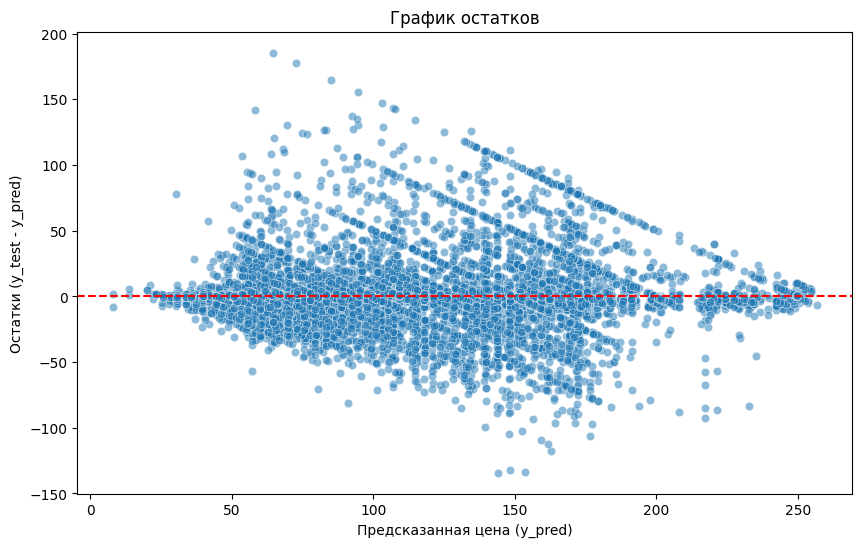

In [9]:
import seaborn as sns
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанная цена (y_pred)')
plt.ylabel('Остатки (y_test - y_pred)')
plt.title('График остатков')
plt.show()